# COVID-19 Forecasting in Bexar County, Texas

In [1]:
SEED = 42
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
# Keras model and layers
import tensorflow as tf
tf.random.set_seed(SEED)

# File path manipulation
from os.path import join as pjoin
import matplotlib.pyplot as plt  # plotting
import pandas as pd  # data loading
from keras.models import Model  # Keras deep learning modules
from keras.layers import Dense, LSTM, Lambda, Input, Multiply
from keras import optimizers
import keras.backend as K
from keras.utils import plot_model

Using TensorFlow backend.


## Worst-Case Parameter
The parameter `WORST_CASE` determines whether to use a parameterization of our model that predicts many cases to come or few. You can play with this and re-run the cells of this notebook to observe difference in forecasts.

In [2]:
WORST_CASE = True

## Other Parameters
Here we define the relative path to the data directory, the look-back parameter `LB` (how many days we consider at a time to forecast), and two normalization parameters `PS` and `MAX_V` (power-normalization).

In [3]:
DATA_DIR = pjoin('..', 'data')

LB = 7
PS = 3
MAX_V = 40

def power_norm(data):
    return np.sign(data) * np.abs(data) ** (1. / PS) / MAX_V

Two functions are used to load and normalize various data. Both min-max and power normalization are used depending on the data modality.

In [4]:
def create_dataset_minmax(ns, fname, look_back=1):
    data_x, data_y = [], []
    max_d = 0
    min_d = 10000
    for c in ns:
        df = pd.read_csv(fname, usecols=[int(c)], engine='python')
        df.dropna(how='all', inplace=True)
        dataset = df.values.astype('float32')
        if np.max(dataset) > max_d:
            max_d = np.max(dataset)
        if np.min(dataset) < min_d:
            min_d = np.min(dataset)
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            data_x.append(a)
            data_y.append(dataset[i + look_back, 0])
    return np.asarray(data_x), np.asarray(data_y), min_d, max_d


def create_dataset_power(ns, fname, look_back=1):
    data_x, data_y = [], []
    for c in ns:
        df = pd.read_csv(fname, usecols=[int(c)], engine='python')
        df.dropna(how='all', inplace=True)
        dataset = df.values.astype('float32')
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            b = dataset[i + look_back, 0]
            a = power_norm(a)
            b = power_norm(b)
            data_x.append(a)
            data_y.append(b)
    return np.asarray(data_x), np.asarray(data_y)

In [5]:
if WORST_CASE:
    loc = np.arange(1, 51 + 1)  # +1 for not inclusive boundary
else:
    loc = np.arange(1, 28 + 1)

train_active, target_active = create_dataset_power(
    loc, pjoin(DATA_DIR, 'Active_cases_data.csv'), LB)

train_total, target_total = create_dataset_power(
    loc, pjoin(DATA_DIR, 'Total_cases_data.csv'), LB)

train1d, _ = create_dataset_power(
    loc, pjoin(DATA_DIR, 'One-day-change_data.csv'), LB)

train2d, _ = create_dataset_power(
    loc, pjoin(DATA_DIR, 'Three-day-change_data.csv'), LB)

train3d, _ = create_dataset_power(
    loc, pjoin(DATA_DIR, 'Seven-day-change_data.csv'), LB)

train_pop, _, min_pop, max_pop = create_dataset_minmax(
    loc, pjoin(DATA_DIR, 'Pop_data.csv'), LB)

train_pop = (train_pop - min_pop) / (max_pop - min_pop)

if WORST_CASE:
    train_pop2 = None  # unused
else:
    train_pop2, _, min_pop2, max_pop2 = create_dataset_minmax(
       loc - 1, pjoin(DATA_DIR, 'TotalPop.csv'), LB)
    train_pop2 = (train_pop2 - min_pop2) / (max_pop2 - min_pop2)

train_med, _, min_med, max_med = create_dataset_minmax(
    loc, pjoin(DATA_DIR, 'Med_data.csv'), LB)

train_med = (train_med - min_med) / (max_med - min_med)

to_stack = [train_active,
            train_total,
            train1d,
            train2d,
            train3d,
            train_pop,
            train_med]
if False and not WORST_CASE:  # TODO - temporarily disabled
    to_stack.append(train_pop2)

trainX = np.stack(to_stack, axis=2)
trainY = np.stack((target_active, target_total), axis=1)

Normalize the data according to some statistics of the Bexar area and define some common attributes of the data. `num_r` sets the number of runs to perform for the model.

In [6]:
num_r = 1
if WORST_CASE:
    fcl = 90
else:
    fcl = 180
num_t = 7
num_f = 2
num_f2 = 7

BEXAR_POP = 1975000
test_pop = 1553
test_med = (7839. / BEXAR_POP) * 10000

test_pop = (test_pop - min_pop) / (max_pop - min_pop)
test_med = (test_med - min_med) / (max_med - min_med)

if WORST_CASE:
    test_pop2 = None  # N/A
else:
    test_pop2 = (BEXAR_POP - min_pop2) / (max_pop2 - min_pop2)

test_active = np.asarray([29, 29, 39, 45, 56, 68, 81])  # /BexarPop
test_total = np.asarray([29, 29, 39, 45, 57, 69, 84])  # /BexarPop
test1d = np.asarray([4, 0, 10, 6, 12, 12, 15])  # /BexarPop
test2d = np.asarray([29, 29, 14, 16, 28, 30, 39])  # /BexarPop
test3d = np.asarray([29, 29, 39, 45, 57, 69, 84])  # /BexarPop

test_active = power_norm(test_active)
test_total = power_norm(test_total)
test1d = power_norm(test1d)
test2d = power_norm(test2d)
test3d = power_norm(test3d)

## Main Loop
Here, the model is trained and transferred to a stateful model. Depending on `WORST_CASE`, the model hyperparameters are modified. The model is visualized further below.

In [7]:
total_pred = np.zeros((1, fcl))
active_pred = np.zeros((1, fcl))

for m_run in range(num_r):
    K.clear_session()

    # Create the LSTM model for training
    all_inp = Input(shape=(num_t, num_f2))
    rec_inp = Lambda(lambda x: x[:, :, :num_f], name='RecIn')(all_inp)
    if WORST_CASE:
        hid_inp = Lambda(lambda x: x[:, -1, 4:], name='HIn')(all_inp)
        hid_size = d2_size = 500
    else:
        hid_inp = Lambda(lambda x: x[:, -1, 5:7], name='HIn')(all_inp)
        hid_size = d2_size = 50
    rec_out = LSTM(hid_size, input_shape=(num_t, num_f), return_sequences=False)(rec_inp)
    dense2 = Dense(d2_size, activation='sigmoid')(hid_inp)
    merge = Multiply()([rec_out, dense2])
    out = Dense(2, activation='relu')(merge)

    CoVid = Model(all_inp, out)
    optimizer = optimizers.SGD(lr=0.1)
    CoVid.compile(loss='mean_squared_error', optimizer=optimizer)
    CoVid.fit(trainX, trainY, epochs=100, batch_size=40, verbose=1)

    # Create the stateful LSTM model for testing
    all_inp_i = Input(batch_shape=(1, None, num_f2))
    rec_inp_i = Lambda(lambda x: x[:, :, :num_f], name='RecInI')(all_inp_i)
    if WORST_CASE:
        hid_inp_i = Lambda(lambda x: x[:, -1, 4:], name='HInI')(all_inp_i)
    else:
        hid_inp_i = Lambda(lambda x: x[:, -1, 5:7], name='HInI')(all_inp_i)
    rec_out_i = LSTM(hid_size, input_shape=(None, num_f), return_sequences=False,
                     stateful=True)(rec_inp_i)
    dense2_i = Dense(d2_size, activation='sigmoid')(hid_inp_i)
    merge_i = Multiply()([rec_out_i, dense2_i])
    out_i = Dense(2, activation='relu')(merge_i)

    CoVidI = Model(all_inp_i, out_i)

    WT = CoVid.get_weights()
    CoVidI.set_weights(WT)

    f1 = np.reshape(test_active, (1, LB, 1))
    f2 = np.reshape(test_total, (1, LB, 1))
    f3 = np.reshape(test1d, (1, LB, 1))
    f4 = np.reshape(test2d, (1, LB, 1))
    f5 = np.reshape(test3d, (1, LB, 1))
    f6 = np.reshape([test_pop] * LB, (1, LB, 1))
    f7 = np.reshape([test_med] * LB, (1, LB, 1))
    f_to_concat = [f1, f2, f3, f4, f5, f6, f7]
    
    gtl = 7
    if WORST_CASE:
        t_start = 0
    else:
        # TODO - Temporarily disabled
        #f8 = np.reshape([test_pop2] * LB, (1, LB, 1))
        #f_to_concat.append(f8)
        
        t_start = gtl

    init_x = np.concatenate(f_to_concat, axis=2)
    total_pred_t = np.zeros((1, fcl))
    active_pred_t = np.zeros((1, fcl))
    
    for tp in range(t_start, fcl):
        if tp < gtl:
            if WORST_CASE:
                init_f = init_x[0, tp, :]
                init_f = np.reshape(init_f, (1, 1, num_f2))
            single_pred = CoVidI.predict(init_f)
            active_pred_t[0, tp] = np.power(
                (np.float32(single_pred[0][0])) * MAX_V, PS)
        else:
            prev_x = init_x
            oi = prev_x[0, 1:, :]
            if WORST_CASE:
                init_f = init_x[0, -1, :]
                init_f = np.reshape(init_f, (1, 1, num_f2))
                single_pred = CoVidI.predict(init_f)
            else:
                single_pred = CoVidI.predict(init_x)

            prev_t7 = np.power(prev_x[0, 0, 1] * MAX_V, PS)
            prev_t3 = np.power(prev_x[0, 4, 1] * MAX_V, PS)
            prev_t1 = np.power(prev_x[0, -1, 1] * MAX_V, PS)

            current_t = np.power(np.float32(single_pred[0][1]) * MAX_V, PS)

            f3 = np.max([0, (current_t - prev_t1)])
            f4 = np.max([0, (current_t - prev_t3)])
            f5 = np.max([0, (current_t - prev_t7)])

            f3 = power_norm(f3)
            f4 = power_norm(f4)
            f5 = power_norm(f5)

            if WORST_CASE:
                ci_dim1 = 2
            else:
                #ci_dim1 = 3  # TODO - temporarily disabled
                ci_dim1 = 2
            ci = np.reshape(prev_x[0, -1, 5:], (1, ci_dim1))
            di = np.reshape(np.asarray([f3, f4, f5]), (1, 3))
            complete_in = np.concatenate((single_pred, di, ci), axis=1)
            init_x = np.concatenate((oi, complete_in), axis=0)
            init_x = np.reshape(init_x, (1, LB, num_f2))

            total_pred_t[0, tp] = np.power(
                (np.float32(single_pred[0][1])) * MAX_V, PS)
            active_pred_t[0, tp] = np.power(
                (np.float32(single_pred[0][0]) * MAX_V), PS)

    total_pred = total_pred + total_pred_t / num_r
    active_pred = active_pred + active_pred_t / num_r

Epoch 1/100
2907/2907 [==============================] - 3s 977us/step - loss: 0.0359
Epoch 2/100
2907/2907 [==============================] - 3s 1ms/step - loss: 0.0335
Epoch 3/100
2907/2907 [==============================] - 3s 922us/step - loss: 0.0319
Epoch 4/100
2907/2907 [==============================] - 3s 933us/step - loss: 0.0307
Epoch 5/100
2907/2907 [==============================] - 3s 873us/step - loss: 0.0298
Epoch 6/100
2907/2907 [==============================] - 2s 840us/step - loss: 0.0292
Epoch 7/100
2907/2907 [==============================] - 2s 819us/step - loss: 0.0288
Epoch 8/100
2907/2907 [==============================] - 2s 856us/step - loss: 0.0285
Epoch 9/100
2907/2907 [==============================] - 3s 900us/step - loss: 0.0283
Epoch 10/100
2907/2907 [==============================] - 3s 925us/step - loss: 0.0282
Epoch 11/100
2907/2907 [==============================] - 2s 859us/step - loss: 0.0235
Epoch 12/100
2907/2907 [==============================

2907/2907 [==============================] - 3s 964us/step - loss: 6.4827e-04
Epoch 94/100
2907/2907 [==============================] - 3s 953us/step - loss: 6.4099e-04
Epoch 95/100
2907/2907 [==============================] - 3s 1ms/step - loss: 6.3612e-04
Epoch 96/100
2907/2907 [==============================] - 3s 1ms/step - loss: 6.2945e-04
Epoch 97/100
2907/2907 [==============================] - 3s 1ms/step - loss: 6.2449e-04
Epoch 98/100
2907/2907 [==============================] - 3s 1ms/step - loss: 6.1841e-04
Epoch 99/100
2907/2907 [==============================] - 3s 982us/step - loss: 6.1497e-04
Epoch 100/100
2907/2907 [==============================] - 3s 901us/step - loss: 6.0936e-04


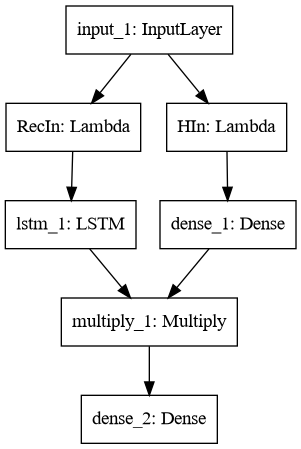

In [8]:
plot_model(CoVid)

Last, we plot the results of the forecast for the Bexar county in Texas.

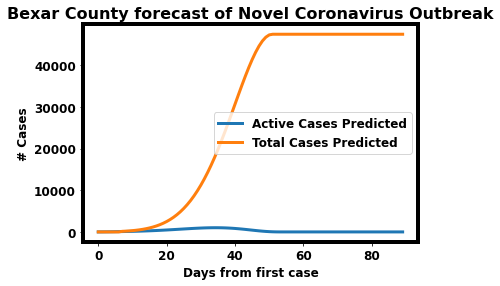

In [9]:
plt.rcParams.update({  # font.weight
    'axes.linewidth': 4,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'legend.fontsize': 'large',
    'lines.linewidth': 3,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.weight': 'bold'
})
active = active_pred.squeeze()
total = total_pred.squeeze()
# Post-processing - total cannot ever decrease in reality
maxv = -np.inf
for i in range(len(total)):
    if total[i] > maxv:
        maxv = total[i]
    else:
        total[i] = maxv

plt.plot(active)
plt.plot(total)
plt.xlabel('Days from first case')
plt.ylabel('# Cases')
plt.title('Bexar County forecast of Novel Coronavirus Outbreak')
plt.legend(['Active Cases Predicted', 'Total Cases Predicted'])
plt.show()